In [1]:
# INIT

import ipaddress
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
from collections import Counter
import ast
import matplotlib.colors as mcolors
import maxminddb
from itertools import combinations

def ip_to_subnet(ip):
   try:
       return str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"
   except:
       return None

def ip_to_asn(ip_address, db_path='data/external/GeoLite2-ASN.mmdb'):
    try:
        with maxminddb.open_database(db_path) as reader:
            result = reader.get(ip_address)
            return result['autonomous_system_organization']
    except Exception as e:
        return None
   
def set_plt_latex_format():
    plt.rcParams.update({
        "font.size": 12,          # Base font size
        "axes.titlesize": 12,     # Title size
        "axes.labelsize": 10,     # Axis label size
        "xtick.labelsize": 10,    # X-tick label size
        "ytick.labelsize": 10,    # Y-tick label size
        "legend.fontsize": 12,    # Legend font size
        "figure.titlesize": 12,    # Figure title size
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })

def retrieve_color_palette(n_colors=10, blends=None):
    if blends is None or len(blends) < 2:
        blends = ['#c40d1e', '#9013fe']  # Default red to purple
    
    # Convert all hex colors to RGB
    rgb_colors = [np.array(mcolors.hex2color(color)) for color in blends]
    
    # Calculate how many segments we need
    segments = len(blends) - 1
    colors_per_segment = n_colors // segments
    extra_colors = n_colors % segments  # Distribute remainder colors among segments
    
    # Create the color list
    colors = []
    
    for i in range(segments):
        start_color = rgb_colors[i]
        end_color = rgb_colors[i+1]
        
        # Calculate how many colors for this segment (distribute remainder)
        segment_colors = colors_per_segment + (1 if i < extra_colors else 0)
        
        # Create colors for this segment
        for j in range(segment_colors):
            if segment_colors > 1:  # Avoid division by zero
                t = j / (segment_colors - 1)
            else:
                t = 0
            color = tuple(start_color + (end_color - start_color) * t)
            colors.append(color)
    
    # Create matplotlib colormap and seaborn palette
    custom_cmap = mcolors.ListedColormap(colors)
    #custom_palette = sns.color_palette(colors, n_colors=len(colors))
    
    return colors, custom_cmap#, custom_palette

servers = {}
with open('.env', 'r') as f:
    for line in f:
        if '=' in line:
            key, value = line.strip().split('=', 1)
            servers[key] = value
            
folder_path=Path("data/packets/ams")
node = str.split(str(folder_path), '/')[-1]
my_ip = servers[node]
default_port = "18080"

In [2]:
peer_packets_df = pd.read_parquet(f'data/dataframes/peer_packets_{node}.parquet')
peers_df = pd.read_parquet(f"data/dataframes/peers_{node}.parquet")

In [3]:
def create_result_df(peer_packets_df):
    grouped = peer_packets_df.groupby('source_ip')

    result_df = pd.DataFrame()

    result_df['source_ip'] = grouped['source_ip'].first()
    result_df['packet_count'] = grouped.size()
    result_df['unique_commands'] = grouped['command'].nunique()
    result_df['my_ports'] = grouped['my_port'].apply(lambda x: x.dropna().astype(int).unique().tolist())
    result_df['unique_my_ports'] = grouped['my_port'].nunique()
    result_df['rpc_ports'] = grouped['rpc_port'].apply(lambda x: x.dropna().astype(int).unique().tolist())
    result_df['unique_rpc_ports'] = grouped['rpc_port'].nunique()
    result_df['peer_ids'] = grouped['peer_id'].apply(lambda x: x.dropna().unique().tolist())
    result_df['unique_peer_ids'] = grouped['peer_id'].nunique()
    result_df['has_support_flags'] = grouped['support_flags'].apply(lambda x: x.notna().any())
    result_df['unique_source_ports'] = grouped['source_port'].nunique()

    return pd.DataFrame(result_df)

result_df = create_result_df(peer_packets_df)
quantiles = [0.5, 0.75, 0.9, 0.99]
stats = ['packet_count', 'unique_my_ports', 'unique_peer_ids', 'unique_source_ports', 'unique_rpc_ports']
#print(result_df.head())
print("-"*50)
print(f"Basic stats based on IP")
print("-"*50)
for s in stats:
    print('-'*50)
    print(f"Distribution for {s}")
    print('-'*50)
    for q in quantiles:
        print(f"{q}th: {result_df[s].quantile(q)}")
    print(f"Max: {result_df[s].max()}")

# quick check grouped by peer_id, only relevant for exploration
def create_peer_id_df(peer_packets_df):
    grouped = peer_packets_df.groupby('peer_id')

    result_df = pd.DataFrame()

    result_df['peer_id'] = grouped['peer_id'].first()

    result_df['source_ips'] = grouped['source_ip'].apply(lambda x: x.dropna().unique().tolist())
    result_df['unique_source_ips'] = grouped['source_ip'].nunique()

    return pd.DataFrame(result_df)

peer_id_df = create_peer_id_df(peer_packets_df)
quantiles = [0.5, 0.75, 0.9, 0.999]
stats = ['unique_source_ips']
print("-"*50)
print(f"Basic stats based on Peer ID")
print("-"*50)
for s in stats:
    print('-'*50)
    print(f"Percentile distribution for {s}")
    print('-'*50)
    for q in quantiles:
        print(f"{q}th: {peer_id_df[s].quantile(q)}")
    print(f"Max: {peer_id_df['unique_source_ips'].max()}")

--------------------------------------------------
Basic stats based on IP
--------------------------------------------------
--------------------------------------------------
Distribution for packet_count
--------------------------------------------------
0.5th: 32.0
0.75th: 349.5
0.9th: 865.0
0.99th: 8680.5
Max: 4025535
--------------------------------------------------
Distribution for unique_my_ports
--------------------------------------------------
0.5th: 1.0
0.75th: 1.0
0.9th: 1.0
0.99th: 3.0
Max: 125
--------------------------------------------------
Distribution for unique_peer_ids
--------------------------------------------------
0.5th: 1.0
0.75th: 1.0
0.9th: 1.0
0.99th: 5.0
Max: 21257
--------------------------------------------------
Distribution for unique_source_ports
--------------------------------------------------
0.5th: 1.0
0.75th: 2.0
0.9th: 3.0
0.99th: 12.5
Max: 18075
--------------------------------------------------
Distribution for unique_rpc_ports
-----------

In [4]:
# quick clustering to find shared peer ids among distinct IPs 
def add_peer_id_clusters(result_df, node):
   from collections import defaultdict
   
   # Build graph of connections
   graph = defaultdict(set)
   for _, row in result_df.iterrows():
       ip = row['source_ip']
       for peer_id in row['peer_ids']:
           graph[ip].add(peer_id)
           graph[peer_id].add(ip)
   
   # Find connected components using stack
   visited = set()
   clusters = []
   
   for start_node in graph:
       if start_node in visited:
           continue
           
       cluster = set()
       stack = [start_node]
       
       while stack:
           current_node = stack.pop()
           if node in visited:
               continue
           visited.add(current_node)
           cluster.add(current_node)
           stack.extend(graph[current_node] - visited)
       
       clusters.append(cluster)
   
   # Map IPs to cluster IDs
   ip_to_cluster = {}
   for i, cluster in enumerate(clusters):
       for current_node in cluster:
           if current_node in result_df['source_ip'].values:
               ip_to_cluster[current_node] = i
   
   # Add cluster column
   result_df = result_df.copy()
   result_df[f'peer_id_cluster_{node}'] = result_df['source_ip'].map(ip_to_cluster)
   return result_df

result_df = add_peer_id_clusters(result_df, node)

In [5]:
print(type(default_port))

<class 'str'>


In [6]:
def get_connection_info(row, my_ip, default_port):
    # Determine if outgoing (my_ip uses ephemeral port) or incoming (peer uses ephemeral port)
    if row['source_ip'] == my_ip and row['source_port'] != default_port:
        # Outgoing: my port is ephemeral
        return 'outgoing', row['dst_ip'], f"{my_ip}:{row['source_port']}->{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] != my_ip and row['dst_port'] != default_port:
        # Outgoing: peer is responding, but connection was initiated by me
        return 'outgoing', row['source_ip'], f"{my_ip}:{row['dst_port']}->{row['source_ip']}:{row['source_port']}"
    elif row['source_ip'] == my_ip and row['source_port'] == default_port:
        # Incoming: my port is default
        return 'incoming', row['source_ip'], f"{my_ip}:{default_port}<-{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] != my_ip and row['dst_port'] == default_port:
        # Incoming: I'm responding, but connection was initiated by peer
        return 'incoming', row['dst_ip'], f"{my_ip}:{default_port}<-{row['source_ip']}:{row['source_port']}"
    
def group_per_connection(peer_packets_df, my_ip, default_port):
    all_data = peer_packets_df.copy()
    connection_info = all_data.apply(get_connection_info, axis=1, args=(my_ip, default_port))
    all_data['direction'] = [info[0] for info in connection_info]
    all_data['peer_ip'] = [info[1] for info in connection_info]
    all_data['connection_key'] = [info[2] for info in connection_info]
    
    # Sort by connection and timestamp
    all_data = all_data.sort_values(['connection_key', 'timestamp'])
    all_data['connection_key_cat'] = all_data['connection_key'].astype('category')
    all_data['prev_connection'] = all_data['connection_key_cat'].shift(1)
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()
    
    # Identify connection breaks
    all_data['is_break'] = (
        (all_data['connection_key_cat'] != all_data['prev_connection']) |
        (all_data['time_diff'] > 120) |
        (all_data['time_diff'].isna())
    )
    all_data['connection_id'] = all_data['is_break'].cumsum()
    grouped = all_data.groupby('connection_id')
    
    # initial conn_df with basic info
    valid_conn_ids = grouped.size()[grouped.size() >= 2].index
    conn_info = []
    
    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        source_ip = conn['source_ip'].iloc[0]
        timestamps = np.array(conn['timestamp'])
        duration = timestamps[-1] - timestamps[0]

        

        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        source_ips = np.array(conn['source_ip'])

        my_ip_mask = (source_ips == my_ip)
        peer_ip_mask = (source_ips != my_ip)
        req_mask = (monero_flags == '1')
        resp_mask = (monero_flags == '2')
        ts_mask = (commands == '1002')

        my_ts_resp_mask = (my_ip_mask & resp_mask & ts_mask)
        peer_ts_req_mask = (peer_ip_mask & req_mask & ts_mask)

        diff = len(commands[my_ts_resp_mask]) - len(commands[peer_ts_req_mask])

        conn_info.append({
            'connection_id': conn_id,
            'source_ip': source_ip, 
            'direction': conn['direction'].iloc[0],
            'duration': duration,
            'ts_latency': None,
            'total_pings': None,
            'ping_frequency': None,
            'req_res_diff': diff
        })

    conn_df = pd.DataFrame(conn_info)
    return grouped, conn_df

grouped, conn_df = group_per_connection(peer_packets_df, my_ip, default_port)

#plt.hist(conn_df['req_res_diff'], log=True)

In [7]:
print(grouped.get_group(26148))

        frame_number     source_ip source_port        dst_ip dst_port  \
5078866      1421339  193.142.4.38       37724  164.92.217.0    18080   
5078867      1421342  164.92.217.0       18080  193.142.4.38    37724   
5078868      1421343  164.92.217.0       18080  193.142.4.38    37724   
5078872      1421362  164.92.217.0       18080  193.142.4.38    37724   
5078899      1421448  193.142.4.38       37724  164.92.217.0    18080   
...              ...           ...         ...           ...      ...   
5091905      1471905  164.92.217.0       18080  193.142.4.38    37724   
5092531      1473864  193.142.4.38       37724  164.92.217.0    18080   
5092532      1473866  164.92.217.0       18080  193.142.4.38    37724   
5092564      1473936  164.92.217.0       18080  193.142.4.38    37724   
5092569      1473963  164.92.217.0       18080  193.142.4.38    37724   

                         timestamp command monero_flags tcp_segments  \
5078866 2025-06-02 23:57:16.970025    1001         

In [8]:
def analyze_ts_latency(grouped, conn_df, my_ip):
    all_ts_diffs = []
    my_ts_diffs = []
    
    for idx, row in conn_df.iterrows():
        conn_id = row['connection_id']
        conn = grouped.get_group(conn_id)
        
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        source_ips = np.array(conn['source_ip'])
        
        # peer TS requests
        ts_mask = (commands == '1002') & (monero_flags == '1') & (source_ips != my_ip)
        ts_series = pd.Series(timestamps[ts_mask])
        
        if len(ts_series) > 2 and conn_df.loc[idx, 'req_res_diff'] in range(-1,2): 
            differences = ts_series.diff().dt.total_seconds().dropna()
            all_ts_diffs.extend(differences)
            latency = differences.mean()
            conn_df.loc[idx, 'ts_latency'] = latency
            #if latency > 100:
            #    print(conn)
            #    print(conn_df.loc[idx, 'req_res_diff'])
            #    break
        
        # mine for reference but less details needed
        ts_mask = (commands == '1002') & (monero_flags == '1') & (source_ips == my_ip)
        ts_series = pd.Series(timestamps[ts_mask])
        if len(ts_series) > 2:
            differences = ts_series.diff().dt.total_seconds().dropna()
            my_ts_diffs.extend(differences)
    
    print(f"My TS latency: {np.mean(my_ts_diffs)}")
    print(f"Other TS latency: {np.mean(all_ts_diffs)}")
     
    return conn_df

conn_df = analyze_ts_latency(grouped, conn_df, my_ip=my_ip)

My TS latency: 61.86576917925021
Other TS latency: 77.48251543588938


--------------------------------------------------
Connection's Avg Timed Sync Frequency Analysis:
--------------------------------------------------
42006 individual connections: 85.34137330810756
Max: 857.1922373666667
Percentile distribution: 
    0.5th percentile: 62.18772443349515
    0.75th percentile: 74.67689319736841
    0.9th percentile: 98.33147201282054
    0.99th percentile: 623.5012015650157


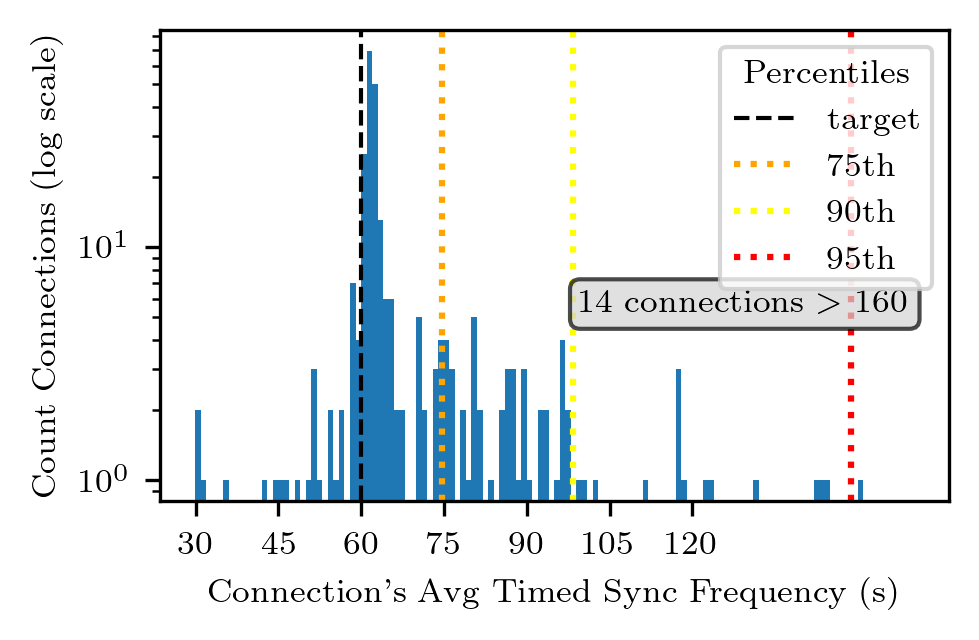

In [9]:
def plot_ts_latency(conn_df):
    quantiles = [0.5, 0.75, 0.9, 0.99]
    print(f"-"*50)
    print(f"Connection\'s Avg Timed Sync Frequency Analysis:")
    print(f"-"*50)
    print(f"{len(conn_df['ts_latency'])} individual connections: {np.mean(conn_df['ts_latency'])}")
    print(f"Max: {conn_df['ts_latency'].max()}")
    print(f"Percentile distribution: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['ts_latency'].quantile(quantile)}")
    set_plt_latex_format()
    plt.figure(figsize=(3.13, 2), dpi=300)
    limit = 160
    plt.hist(conn_df['ts_latency'].dropna(), range=(conn_df['ts_latency'].min(), limit), bins=int(limit-conn_df['ts_latency'].min()), log=True)
    #plt.axvline(result_df['ts_latency'].quantile(0.5), color='orange', linestyle='--', label='50th')
    plt.axvline(60, color='black', linestyle='--', label='target', linewidth=1)
    plt.axvline(conn_df['ts_latency'].quantile(0.75), color='orange', linestyle=':', label='75th')
    plt.axvline(conn_df['ts_latency'].quantile(0.9), color='yellow', linestyle=':', label='90th')
    plt.axvline(conn_df['ts_latency'].quantile(0.95), color='red', linestyle=':', label='95th')
    outlier_count = sum(x > limit for x in conn_df['ts_latency'].dropna())
    plt.text(0.95, 0.45, f'{outlier_count} connections $>$ {limit}', fontsize=8,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Connection\'s Avg Timed Sync Frequency (s)', fontsize=8)
    plt.xticks([30,45,60,75,90,105,120], fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylabel(f'Count Connections (log scale)', fontsize=8)
    plt.legend(title='Percentiles', fontsize=8, title_fontsize=8)
    plt.tight_layout(pad=0.2)
    #plt.savefig('results/graphs/ts_latency_dist.pdf')
    plt.show()

plot_ts_latency(conn_df)


Ping Analysis:
42006 connections.
Percentile distribution of number of Pings sent per connection: 
    0.5th percentile: 23.0
    0.75th percentile: 24.0
    0.9th percentile: 25.0
    0.95th percentile: 26.0
    0.99th percentile: 27.0
Percentile distribution of frequency of Pings if more than one is sent: 
    0.5th percentile: 7.176111608695654
    0.75th percentile: 7.4649630227272725
    0.9th percentile: 7.89515762
    0.95th percentile: 8.184702348157893
    0.99th percentile: 8.738714019789471
0


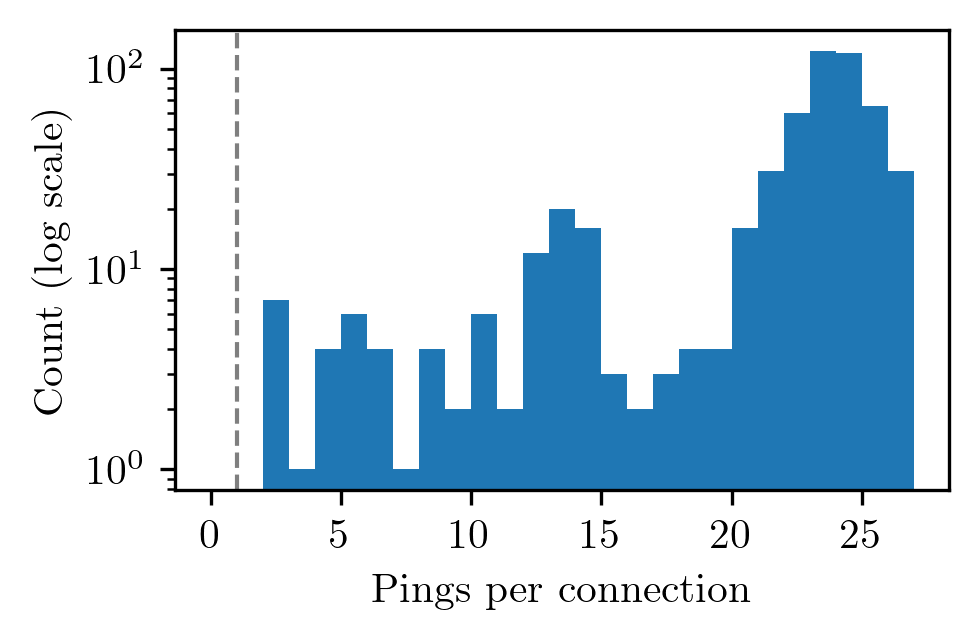

In [10]:
def analyze_ping_flooding(grouped, conn_df, my_ip):
   for idx, row in conn_df.iterrows():
       conn_id = row['connection_id']
       conn = grouped.get_group(conn_id)
       
       commands = np.array(conn['command'])
       monero_flags = np.array(conn['monero_flags'])
       timestamps = np.array(conn['timestamp'])
       source_ips = np.array(conn['source_ip'])
       
       ping_req_mask = (commands == '1003') & (source_ips != my_ip) & (monero_flags == '1')
       ping_req_series = pd.Series(timestamps[ping_req_mask])
       ping_resp_mask = (commands == '1003') & (source_ips == my_ip) & (monero_flags == '2')
       ping_resp_series = pd.Series(timestamps[ping_resp_mask])
       
       # does the peer send pings more often although I responded
       if len(ping_req_series) > 1 and commands[0] == '1001' and len(ping_resp_series) > 0:
           # did I respond before he initiated another ping to avoid issues with my node
           #print(ping_req_series)
           if ping_resp_series.iloc[0] < ping_resp_series.iloc[-1]:
               ping_differences = ping_req_series.diff().dt.total_seconds().dropna()
               total_pings = len(ping_req_series)
               ping_frequency = ping_differences.mean()
               
               conn_df.loc[idx, 'total_pings'] = total_pings
               conn_df.loc[idx, 'ping_frequency'] = ping_frequency
   
   return conn_df
                
conn_df = analyze_ping_flooding(grouped=grouped, conn_df=conn_df, my_ip=my_ip)

def plot_ping_flooding(conn_df):
    # Ping Plots
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99]
    print(f"\nPing Analysis:")
    print(f"{len(conn_df['total_pings'])} connections.")
    print(f"Percentile distribution of number of Pings sent per connection: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['total_pings'].quantile(quantile)}")
    print(f"Percentile distribution of frequency of Pings if more than one is sent: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['ping_frequency'].quantile(quantile)}")
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(conn_df['total_pings'].dropna(), bins=conn_df['total_pings'].max(), range=(0, conn_df['total_pings'].max()), log=True)
    #plt.xlim(0, 35)
    plt.axvline(1, color='black', linestyle='--', linewidth=1, alpha=0.5, label='default')
    #plt.text(1.05, plt.ylim()[1]*0.9, 'default: 1', verticalalignment='top', fontsize=10)
    #plt.axvline(result_df['total_pings'].quantile(0.9), color='orange', linestyle=':', label='90th')
    #plt.axvline(result_df['total_pings'].quantile(0.95), color='red', linestyle=':', label='95th')

    outlier_count = sum(x > 35 for x in conn_df['total_pings'].dropna())
    print(outlier_count)
    plt.xlabel(f'Pings per connection')
    plt.ylabel(f'Count (log scale)')
    #plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

plot_ping_flooding(conn_df)

In [11]:
print(conn_df['duration'].mean())

0 days 00:07:16.825061657


In [ ]:
def classify_connection(conn_row, duration_m, commands, ts_latency_lower, ts_latency_upper, 
                       min_duration_minutes):
    """Classify connection type based on characteristics"""
    
    if commands[0] != '1001':  # Must start with handshake
        return None
    
    if conn_row['ping_frequency'] == None: 
        conn_row['ping_frequency'] = 0
    if conn_row['ts_latency'] == None:
        conn_row['ts_latency'] = 6000
    

    conditions = {
        'standard': (
            (conn_row['ts_latency'] < ts_latency_lower) &
            (conn_row['ping_frequency'] == 0) & 
            (duration_m > timedelta(minutes=min_duration_minutes))
        ),
        'throttled_ts': (
            (conn_row['ts_latency'] > ts_latency_upper) &
            (conn_row['ts_latency'] != 6000) #&
            #(duration_m > timedelta(minutes=min_duration_minutes))
        ),
        'ping': (
            (conn_row['ping_frequency'] > 0) & 
            (conn_row['ping_frequency'] < 10)
        )
    }

    for conn_type, condition in conditions.items():
        
        if condition:
            return f"{conn_type}_{row['direction']}"
    return None

# build connections dataframe 
df_indexed = result_df.set_index('source_ip')

ts_latency_lower = conn_df['ts_latency'].quantile(0.5)
ts_latency_upper = conn_df['ts_latency'].quantile(0.9)

#connection_data = {f"{conn_type}_{direction}": [] for conn_type in ['standard', 'throttled_ts', 'ping'] for direction in ['outgoing', 'incoming']}
#type_counts = {conn_type: 0 for conn_type in connection_data.keys()}

connection_data = {}
type_counts = {}

max_connections_per_type=5
min_duration_minutes=7
min_ping_commands=3
time_duration_seconds=660
peers = []

for idx, row in conn_df.iterrows():
    conn_id = row['connection_id']
    conn = grouped.get_group(conn_id)
    
    commands = np.array(conn['command'])
    monero_flags = np.array(conn['monero_flags'])
    timestamps = np.array(conn['timestamp'])
    source_ips = np.array(conn['source_ip'])

    duration_m=row['duration']

    conn_type = classify_connection(row, duration_m, commands, 
                                      ts_latency_lower, ts_latency_upper, min_duration_minutes)
    if conn_type and not conn_type in type_counts:
        type_counts[conn_type] = 0
    if conn_type and not conn_type in connection_data:
        connection_data[conn_type] = []

    peers_tmp = list(set(source_ips))
    if len(peers_tmp) > 1:
        if peers_tmp[0] == my_ip:
            peer_tmp = peers_tmp[1]
        else:
            peer_tmp = peers_tmp[0]
    
    if (conn_type and type_counts[conn_type] < max_connections_per_type and
            (not conn_type in ['ping_incoming', 'ping_outgoing'] or len(commands[commands == '1003']) >= min_ping_commands) and 
            (conn_type in ['ping_incoming', 'ping_outgoing'] or len(commands[commands == '1002']) >= 20) and
            (not peer_tmp in peers)):
        peers.append(peer_tmp)
        # Prepare base data for plotting
        base_mask = np.isin(commands, ['1001', '1002', '1003'])
        base_series = pd.Series(timestamps[base_mask])
        
        connection_data[conn_type].append({
            'peer': peer_tmp,
            'source_ips': source_ips[base_mask],
            'commands': commands[base_mask],
            'flags': monero_flags[base_mask],
            'series': base_series
        })
        type_counts[conn_type] += 1

        #if conn_type == 'throttled_ts':
        #    print(f"{conn_id} - {source_ips[:20]}")



ping_incoming 1: ['100.42.27.120' '100.42.27.120'] : 0   2025-06-02 23:14:53.867360
dtype: datetime64[ns]
ping_incoming 2: ['100.42.27.130' '100.42.27.130'] : 0   2025-06-03 02:43:00.965112
dtype: datetime64[ns]
ping_incoming 3: ['100.42.27.18' '100.42.27.18'] : 0   2025-06-03 07:33:28.936773
dtype: datetime64[ns]
ping_incoming 4: ['100.42.27.213' '100.42.27.213'] : 0   2025-06-03 03:24:03.584693
dtype: datetime64[ns]
ping_incoming 5: ['100.42.27.21' '100.42.27.21'] : 0   2025-06-02 23:36:17.025347
dtype: datetime64[ns]
standard_incoming 1: ['107.189.15.142' '164.92.217.0'] : 0   2025-06-02 20:23:29.217399
dtype: datetime64[ns]
standard_incoming 2: ['136.243.34.86' '164.92.217.0'] : 0   2025-06-02 10:25:16.760300
dtype: datetime64[ns]
standard_incoming 3: ['136.47.213.244' '164.92.217.0'] : 0   2025-06-02 17:20:20.377422
dtype: datetime64[ns]
standard_incoming 4: ['14.19.214.46' '164.92.217.0'] : 0   2025-06-03 07:31:20.271949
dtype: datetime64[ns]
standard_incoming 5: ['140.180.242.11

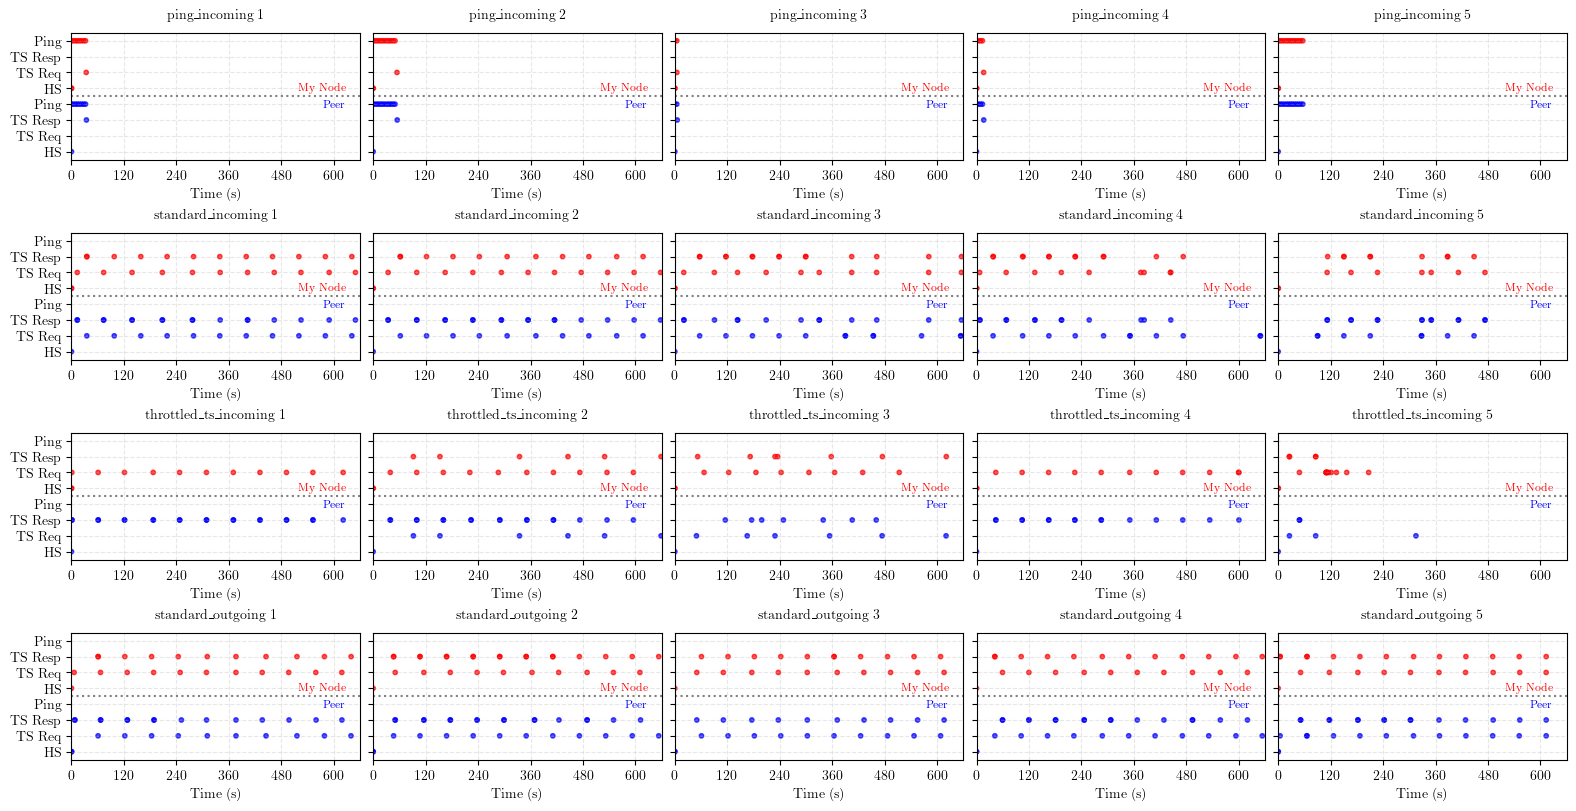

In [ ]:
def get_command_category(cmd, flag, source, my_ip):
    """Map commands and flags to categories"""
    if source == my_ip:
        i = 4
    else:
        i = 0
        
    category_map = {
        ('1001', '1'): 1+i,    # Handshake Request
        ('1001', '2'): 1+i,    # HS Resp
        ('1002', '1'): 2+i,    # Timed Sync Request
        ('1002', '2'): 3+i,    # TS Response
        ('1003', '1'): 4+i,    # Ping
        ('1003', '2'): 4+i     # Pong
    }
    
    return category_map.get((cmd, flag), 0)

def setup_axis_appearance(ax, time_duration_seconds, show_ylabel=True):
    """Configure axis appearance for LaTeX paper"""
    #category_labels = ['Handshake', 'TS Request', 'TS Response', 'Ping']
    category_labels = ['HS', 'TS Req', 'TS Resp', 'Ping', 'HS', 'TS Req', 'TS Resp', 'Ping']

    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_xticks(range(0, time_duration_seconds + 1, 120))
    ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8])
    ax.set_yticklabels(category_labels if show_ylabel else ['', '', '', '', '', '', '', ''], fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylim(0.5, 8.5)
    
    ax.set_xlim(0, time_duration_seconds)
    ax.grid(True, alpha=0.3, linestyle='--')

def plot_command_timeline_subplot(ax, base_commands, base_flags, base_series, base_sources, title, 
                                time_duration_seconds=300, show_ylabel=True):
    """Plot command timeline on given axis"""
    if len(base_series) == 0:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                ha='center', va='center', fontsize=7)
        ax.set_title(title, fontsize=8, pad=8)

        setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
        return
    
    # Convert to seconds from start and filter by duration
    time_seconds = (base_series - base_series.iloc[0]).dt.total_seconds()
    time_mask = time_seconds <= time_duration_seconds
    
    if not time_mask.any():
        ax.text(0.5, 0.5, 'No data in time range', transform=ax.transAxes, 
                ha='center', va='center', fontsize=9)
        ax.set_title(title, fontsize=10, pad=10)
        setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
        return
    
    # Filter data and create categories    
    commands_filtered = base_commands[time_mask]
    flags_filtered = base_flags[time_mask]
    time_filtered = time_seconds[time_mask]
    sources_filtered = base_sources[time_mask]
    
    categories = [get_command_category(cmd, flag, source, my_ip) 
                  for cmd, flag, source in zip(commands_filtered, flags_filtered, sources_filtered)]
    
    print(f"{title}: {sources_filtered[:2]} : {base_series[:1]}")
    
    colors = ['red' if source == my_ip else 'blue' 
          for source in sources_filtered]

    ax.scatter(time_filtered, categories, c=colors, s=10, alpha=0.7)

    ax.axhline(4.5, color='gray', linestyle=':')

    ax.text(time_duration_seconds * 0.95, 4.7, 'My Node', 
            ha='right', va='bottom', fontsize=8, color='red')
    
    # Add text below the line  
    ax.text(time_duration_seconds * 0.95, 4.3, 'Peer', 
            ha='right', va='top', fontsize=8, color='blue')
    
    ax.set_title(title, fontsize=10, pad=10, weight='bold')
    setup_axis_appearance(ax, time_duration_seconds, show_ylabel)

#connection_types = {f"{conn_type}_{direction}": [] for conn_type in ['standard', 'throttled_ts', 'ping'] for direction in ['outgoing', 'incoming']}
titles = list(type_counts.keys()) #['Standard','Standard', 'Throttled Timed Sync','Throttled Timed Sync', 'Ping Flooding','Ping Flooding']

fig, axes = plt.subplots(len(connection_data), max_connections_per_type, 
                    figsize=(3.13*max_connections_per_type, len(connection_data)*2),
                    constrained_layout=True)

if max_connections_per_type == 1:
    axes = axes.reshape(-1, 1)

for i, conn_type in enumerate(connection_data):
    for j in range(max_connections_per_type):
        if j < len(connection_data[conn_type]):
            data = connection_data[conn_type][j]
            title = f"{titles[i]} {j+1}"
            plot_command_timeline_subplot(
                axes[i, j], data['commands'], data['flags'], 
                data['series'], data['source_ips'], title, time_duration_seconds, show_ylabel=(j==0)
            )
        else:
            axes[i, j].text(0.5, 0.5, f'No {conn_type}\nconnection {j+1}', 
                           transform=axes[i, j].transAxes, ha='center', va='center',
                           fontsize=9)
            axes[i, j].set_title(f"{conn_type.title()} {j+1}", fontsize=10, pad=10)
            setup_axis_appearance(axes[i, j], time_duration_seconds, show_ylabel=(j==0))
